## Import Packages

In [1]:
import numpy as np
import pandas as pd
import pymatgen as pmg
import time
import matplotlib.pyplot as plt

from matminer.datasets.dataframe_loader import load_elastic_tensor
from matminer.utils.conversions import str_to_composition
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as struc
from matminer.featurizers.base import MultipleFeaturizer

from pymatgen import MPRester

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

### Loading pickle file

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')

### Part 1: Specifying input data

Here, we specify several different data sizes so that we can quantify performance of some machine learning algorithms with respect to the data input size. 

In [66]:
size = [10, 50, 100, 500, data.shape[0]]

variable_data = []
for i in range(len(size)):
    variable_data.append(shuffle(data)[:size[i]])

Elastic moduli value that we wish to predict. Choose from: "K_VRH" or "G_VRH"

In [67]:
learned_feature = 'K_VRH'

##### Input X and y
We impute X and assign log of K_VRH/G_VRH to y

In [68]:
original_columns = ['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition']

X = []
y = []
I = Imputer()
for i in range(len(variable_data)):
    x = variable_data[i].drop(original_columns, 1)
    X.append(I.fit_transform(x))
    y.append(np.log(variable_data[i][learned_feature]).as_matrix())

### Part 2: Choosing different ML models

We use several different ML algorithms to train the training set. Time performance and accuracy of the predictions of the respective models are printed. 


In [69]:
m = len(size)

#### 1) Generalized Linear Models: Linear Regression

In [70]:
mae_lr, rmse_lr, r2_lr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [71]:
time_lr = np.zeros((m,))

In [72]:
print ("Linear Regression: ")
start_lr = time.monotonic()
for i in range(m):
    start_lr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        lr = linear_model.LinearRegression()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        lr.fit(x_train, y_train)
        y_pred = lr.predict(x_test)

        mae_lr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_lr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_lr[i] += r2_score(y_test, y_pred) / num_splits

    finish_lr = time.monotonic()
    time_lr[i] = finish_lr - start_lr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_lr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_lr[i], rmse_lr[i], r2_lr[i]))
print ()

Linear Regression: 
-- Size of dataset: 10
Time: 0.013637 seconds
MAE = 0.710271, RMSE = 7.102709, R-SQUARED = 0.000000
-- Size of dataset: 50
Time: 0.014480 seconds
MAE = 0.693330, RMSE = 10.278672, R-SQUARED = -20.883574
-- Size of dataset: 100
Time: 0.025279 seconds
MAE = 1.551447, RMSE = 23.733338, R-SQUARED = -26.322793
-- Size of dataset: 500
Time: 0.042542 seconds
MAE = 0.156607, RMSE = 2.295156, R-SQUARED = 0.862464
-- Size of dataset: 1181
Time: 0.096858 seconds
MAE = 0.138232, RMSE = 1.988590, R-SQUARED = 0.912731



#### 2) Generalized Linear Model:  Ridge Regression

In [73]:
mae_ridge, rmse_ridge, r2_ridge = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [74]:
time_ridge = np.zeros((m,))

In [75]:
print ("Ridge Regression: ")
for i in range(m):
    start_ridge = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        ridge = linear_model.RidgeCV()
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        ridge.fit(x_train, y_train)
        y_pred = ridge.predict(x_test)

        mae_ridge[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_ridge[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_ridge[i] += r2_score(y_test, y_pred) / num_splits
    finish_ridge = time.monotonic()
    time_ridge[i] = finish_ridge - start_ridge
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_ridge[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_ridge[i], rmse_ridge[i], r2_ridge[i]))
print ()

Ridge Regression: 
-- Size of dataset: 10
Time: 0.012175 seconds
MAE = 0.718918, RMSE = 7.189180, R-SQUARED = 0.000000
-- Size of dataset: 50
Time: 0.016360 seconds
MAE = 0.268605, RMSE = 3.393346, R-SQUARED = 0.274932
-- Size of dataset: 100
Time: 0.035043 seconds
MAE = 0.212537, RMSE = 2.693675, R-SQUARED = 0.808235
-- Size of dataset: 500
Time: 0.105788 seconds
MAE = 0.149470, RMSE = 2.177575, R-SQUARED = 0.880446
-- Size of dataset: 1181
Time: 0.218091 seconds
MAE = 0.140605, RMSE = 2.007464, R-SQUARED = 0.911296



Plot performances of both linear models

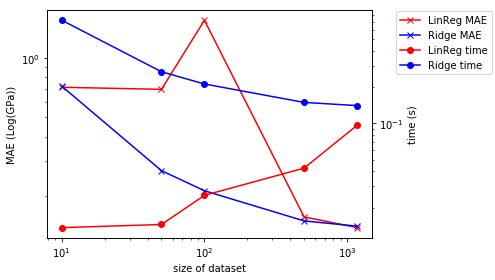

In [76]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg MAE')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o', label='LinReg time')
ax2.loglog(size, mae_ridge, color='b', marker='o', label='Ridge time')

fig.legend(bbox_to_anchor=(1.15, 0.95))
fig.tight_layout()
plt.show()

#### 3) Ensemble method: RandomForestRegressor 

100 estimators are used

In [77]:
num_trees = 100

In [78]:
mae_rfr, rmse_rfr, r2_rfr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [79]:
time_rfr = np.zeros((m,))

In [80]:
print ("Random Forest Regression: ")
for i in range(m):
    start_rfr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        rfr = RandomForestRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        rfr.fit(x_train, y_train)
        y_pred = rfr.predict(x_test)

        mae_rfr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_rfr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_rfr[i] += r2_score(y_test, y_pred) / num_splits
    finish_rfr = time.monotonic()
    time_rfr[i] = finish_rfr - start_rfr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_rfr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_rfr[i], rmse_rfr[i], r2_rfr[i]))
print ()

Random Forest Regression: 
-- Size of dataset: 10
Time: 1.063651 seconds
MAE = 0.339766, RMSE = 3.397664, R-SQUARED = 0.000000
-- Size of dataset: 50
Time: 1.525462 seconds
MAE = 0.253689, RMSE = 3.093309, R-SQUARED = 0.576978
-- Size of dataset: 100
Time: 2.740750 seconds
MAE = 0.252886, RMSE = 3.419594, R-SQUARED = 0.709050
-- Size of dataset: 500
Time: 15.011919 seconds
MAE = 0.175914, RMSE = 2.586962, R-SQUARED = 0.837083
-- Size of dataset: 1181
Time: 40.405340 seconds
MAE = 0.153101, RMSE = 2.320611, R-SQUARED = 0.881081



Plot performance

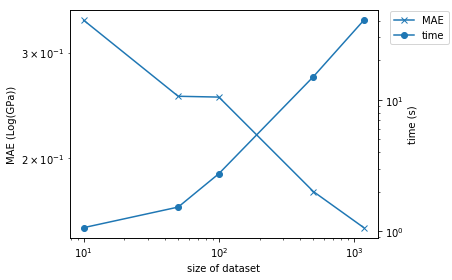

In [81]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_rfr, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_rfr, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.05, 0.95))
fig.tight_layout()
plt.show()

#### 4) Ensemble method: ExtraTreesRegressor

In [82]:
mae_efr, rmse_efr, r2_efr = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [83]:
time_efr = np.zeros((m,))

In [84]:
print ("Extra Trees Regression: ")
for i in range(m):
    start_efr = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        efr = ExtraTreesRegressor(n_estimators=num_trees)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        efr.fit(x_train, y_train)
        y_pred = efr.predict(x_test)

        mae_efr[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_efr[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_efr[i] += r2_score(y_test, y_pred) / num_splits
    finish_efr = time.monotonic()
    time_efr[i] = finish_efr - start_efr
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_efr[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_efr[i], rmse_efr[i], r2_efr[i]))
print ()

Extra Trees Regression: 
-- Size of dataset: 10
Time: 0.956963 seconds
MAE = 0.385833, RMSE = 3.858330, R-SQUARED = 0.000000
-- Size of dataset: 50
Time: 1.683833 seconds
MAE = 0.254826, RMSE = 3.101589, R-SQUARED = 0.581837
-- Size of dataset: 100
Time: 2.137514 seconds
MAE = 0.214674, RMSE = 2.962353, R-SQUARED = 0.758864
-- Size of dataset: 500
Time: 8.228081 seconds
MAE = 0.161896, RMSE = 2.434588, R-SQUARED = 0.854148
-- Size of dataset: 1181
Time: 18.393696 seconds
MAE = 0.132910, RMSE = 2.104636, R-SQUARED = 0.902587



Plot performance

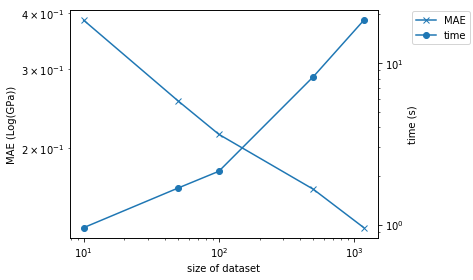

In [85]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_efr, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_efr, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()
plt.show()

#### 5) Ensemble method: GradientBoosting 

In [86]:
mae_gradient, rmse_gradient, r2_gradient = np.zeros((m,)), np.zeros((m,)), np.zeros((m,))

In [87]:
time_gradient = np.zeros((m,))

In [88]:
print ("Gradient Boosting Regression: ")
for i in range(m):
    start_gradient = time.monotonic()
    for train_index, test_index in kfold.split(X[i]):
        gradient = GradientBoostingRegressor(n_estimators=250, max_depth=3)
        x_train, x_test = X[i][train_index], X[i][test_index]
        y_train, y_test = y[i][train_index], y[i][test_index]
        gradient.fit(x_train, y_train)
        y_pred = gradient.predict(x_test)

        mae_gradient[i] += mean_absolute_error(y_true=y_test, y_pred=y_pred)/num_splits
        rmse_gradient[i] += np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
        r2_gradient[i] += r2_score(y_test, y_pred) / num_splits
    finish_gradient = time.monotonic()
    time_gradient[i] = finish_gradient - start_gradient
    print ("-- Size of dataset: %i" %size[i])
    print ("Time: %f seconds" %time_gradient[i])
    print ("MAE = %f, RMSE = %f, R-SQUARED = %f" %(mae_gradient[i], rmse_gradient[i], r2_gradient[i]))
print ()

Gradient Boosting Regression: 
-- Size of dataset: 10
Time: 0.347401 seconds
MAE = 0.349860, RMSE = 3.498596, R-SQUARED = 0.000000
-- Size of dataset: 50
Time: 0.762789 seconds
MAE = 0.283102, RMSE = 3.386255, R-SQUARED = 0.494195
-- Size of dataset: 100
Time: 2.087767 seconds
MAE = 0.258856, RMSE = 3.512189, R-SQUARED = 0.688849
-- Size of dataset: 500
Time: 8.837387 seconds
MAE = 0.155879, RMSE = 2.380498, R-SQUARED = 0.853651
-- Size of dataset: 1181
Time: 21.275985 seconds
MAE = 0.122211, RMSE = 1.873643, R-SQUARED = 0.921898



Plot performance

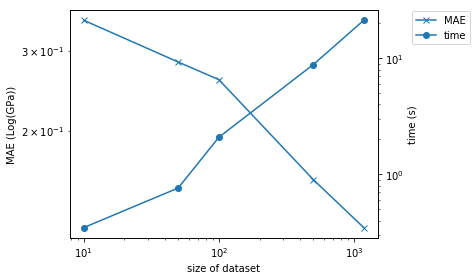

In [89]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('size of dataset')
ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_gradient, marker='x', label='MAE')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_gradient, marker='o', label='time')

fig.legend(bbox_to_anchor=(1.1, 0.95))
fig.tight_layout()
plt.show()

#### Quantifying trade off of time performance and accuracy of model with respect to size of data 

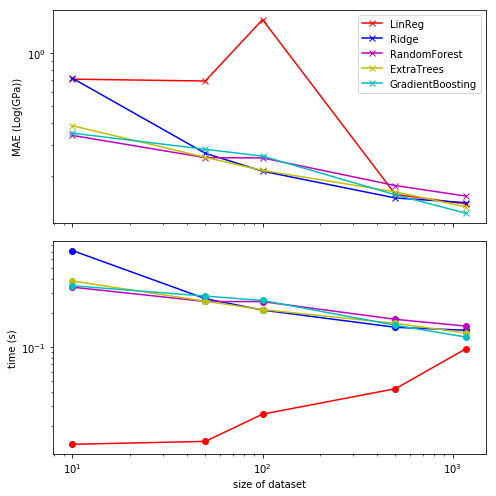

In [90]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_ylabel('MAE (Log(GPa))')
ax1.loglog(size, mae_lr, color='r', marker='x', label='LinReg')
ax1.loglog(size, mae_ridge, color='b', marker='x', label='Ridge')
ax1.loglog(size, mae_rfr, color='m', marker='x', label='RandomForest')
ax1.loglog(size, mae_efr, color='y', marker='x', label='ExtraTrees')
ax1.loglog(size, mae_gradient, color='c', marker='x', label='GradientBoosting')
ax1.legend()

ax2.set_ylabel('time (s)')
ax2.loglog(size, time_lr, color='r', marker='o')
ax2.loglog(size, mae_ridge, color='b', marker='o')
ax2.loglog(size, mae_rfr, color='m', marker='o')
ax2.loglog(size, mae_efr, color='y', marker='o')
ax2.loglog(size, mae_gradient, color='c', marker='o')

ax2.set_xlabel('size of dataset')

fig.set_size_inches(7, 7)
fig.tight_layout()
plt.show()

*Finding*: RMSE of K is a few orders of magnitude larger than in De Jong's paper. RMSE of G is ten times larger.